# Testing data from Nemosis

In [3]:
import pandas as pd

import glob

In [2]:
data_path = "/g/data/w42/dr6273/tmp/"

In [101]:
files = sorted(glob.glob(data_path+"*TRADING*.CSV"))
files[:3]

['/g/data/w42/dr6273/tmp/PUBLIC_DVD_TRADINGREGIONSUM_200912010000.CSV',
 '/g/data/w42/dr6273/tmp/PUBLIC_DVD_TRADINGREGIONSUM_201001010000.CSV',
 '/g/data/w42/dr6273/tmp/PUBLIC_DVD_TRADINGREGIONSUM_201002010000.CSV']

In [104]:
files[-49]

'/g/data/w42/dr6273/tmp/PUBLIC_DVD_TRADINGREGIONSUM_201701010000.CSV'

In [102]:
def open_df(path):
    return pd.read_csv(
        path,
        header=1,
        usecols=["REGIONID", "SETTLEMENTDATE", "TOTALDEMAND"],
        parse_dates=["SETTLEMENTDATE"],
        index_col="SETTLEMENTDATE",
    )

In [105]:
d = open_df(files[-49])

In [107]:
d[d.REGIONID == "QLD1"]

,REGIONID,TOTALDEMAND
SETTLEMENTDATE,,
2017-01-01 00:30:00,QLD1,6462.14
2017-01-01 01:00:00,QLD1,6352.82
2017-01-01 01:30:00,QLD1,6261.02
2017-01-01 02:00:00,QLD1,6169.66
2017-01-01 02:30:00,QLD1,6149.87
...,...,...
2017-01-31 22:00:00,QLD1,7611.94
2017-01-31 22:30:00,QLD1,7265.97
2017-01-31 23:00:00,QLD1,7117.27


In [108]:
dfs = [open_df(f) for f in files]

In [109]:
df2 = pd.concat(dfs)

In [118]:
df2.loc[df2.REGIONID == "NSW1"].drop_duplicates().loc["2017"]

,REGIONID,TOTALDEMAND
SETTLEMENTDATE,,
2017-01-01 00:00:00,NSW1,7431.17
2017-01-01 00:30:00,NSW1,7259.07
2017-01-01 01:00:00,NSW1,7046.41
2017-01-01 01:30:00,NSW1,6845.24
2017-01-01 02:00:00,NSW1,6629.92
...,...,...
2017-12-31 21:00:00,NSW1,7268.84
2017-12-31 21:30:00,NSW1,7389.58
2017-12-31 22:00:00,NSW1,7415.33


In [127]:
df2.loc[df2.REGIONID == "QLD1"].loc["2017"]

,REGIONID,TOTALDEMAND
SETTLEMENTDATE,,
2017-01-01 00:00:00,QLD1,6728.99
2017-01-01 00:30:00,QLD1,6462.14
2017-01-01 01:00:00,QLD1,6352.82
2017-01-01 01:30:00,QLD1,6261.02
2017-01-01 02:00:00,QLD1,6169.66
...,...,...
2017-12-31 21:30:00,QLD1,6855.11
2017-12-31 22:00:00,QLD1,6781.15
2017-12-31 22:30:00,QLD1,6715.13


In [128]:
df2.loc[df2.REGIONID == "QLD1"].loc["2017"].drop_duplicates()

,REGIONID,TOTALDEMAND
SETTLEMENTDATE,,
2017-01-01 00:00:00,QLD1,6728.99
2017-01-01 00:30:00,QLD1,6462.14
2017-01-01 01:00:00,QLD1,6352.82
2017-01-01 01:30:00,QLD1,6261.02
2017-01-01 02:00:00,QLD1,6169.66
...,...,...
2017-12-31 21:30:00,QLD1,6855.11
2017-12-31 22:00:00,QLD1,6781.15
2017-12-31 22:30:00,QLD1,6715.13


In [129]:
# df2 = df2.drop_duplicates()

In [62]:
df

,REGIONID,TOTALDEMAND
SETTLEMENTDATE,,
2009-12-01 00:05:00,NSW1,7565.67
2009-12-01 00:05:00,QLD1,5817.96
2009-12-01 00:05:00,SA1,1399.56
2009-12-01 00:05:00,TAS1,1039.38
2009-12-01 00:05:00,VIC1,4884.23
...,...,...
2021-01-31 11:00:00,SA1,491.68
2021-01-31 11:00:00,VIC1,3369.94
2021-01-31 11:05:00,SA1,440.63


In [130]:
df2[df2.REGIONID == "QLD1"]

,REGIONID,TOTALDEMAND
SETTLEMENTDATE,,
2009-12-01 00:30:00,QLD1,5723.40
2009-12-01 01:00:00,QLD1,5532.81
2009-12-01 01:30:00,QLD1,5415.17
2009-12-01 02:00:00,QLD1,5270.51
2009-12-01 02:30:00,QLD1,5206.92
...,...,...
2021-01-31 22:00:00,QLD1,7028.43
2021-01-31 22:30:00,QLD1,6871.32
2021-01-31 23:00:00,QLD1,6684.62


In [86]:
df2.index[0]

Timestamp('2009-12-01 00:30:00')

In [87]:
df2.index[-1]

Timestamp('2021-02-01 00:00:00')

In [89]:
pd.date_range(df2.index[0], df2.index[-1], freq="30min")

DatetimeIndex(['2009-12-01 00:30:00', '2009-12-01 01:00:00',
               '2009-12-01 01:30:00', '2009-12-01 02:00:00',
               '2009-12-01 02:30:00', '2009-12-01 03:00:00',
               '2009-12-01 03:30:00', '2009-12-01 04:00:00',
               '2009-12-01 04:30:00', '2009-12-01 05:00:00',
               ...
               '2021-01-31 19:30:00', '2021-01-31 20:00:00',
               '2021-01-31 20:30:00', '2021-01-31 21:00:00',
               '2021-01-31 21:30:00', '2021-01-31 22:00:00',
               '2021-01-31 22:30:00', '2021-01-31 23:00:00',
               '2021-01-31 23:30:00', '2021-02-01 00:00:00'],
              dtype='datetime64[ns]', length=195840, freq='30T')

/jobfs/95687832.gadi-pbs/ipykernel_3620848/3353393575.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  (df2.loc[df2.REGIONID == "QLD1"].loc["2017-01"].resample("1H").mean()).plot(ylim=(0, 10000))


<AxesSubplot: xlabel='SETTLEMENTDATE'>

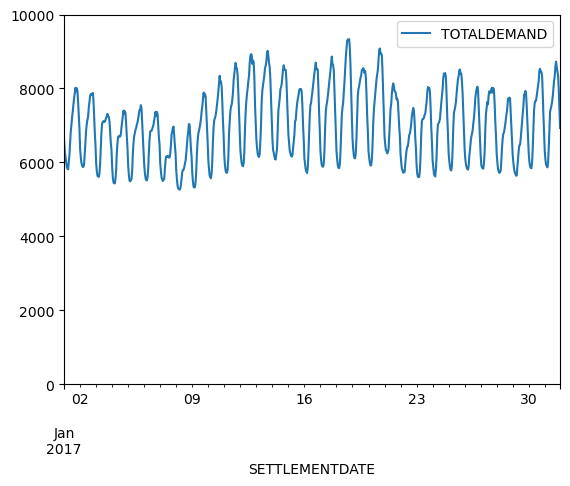

In [141]:
(df2.loc[df2.REGIONID == "QLD1"].loc["2017-01"].resample("1H").mean()).plot(ylim=(0, 10000))

In [140]:
(df2.loc[df2.REGIONID == "QLD1"].loc["2017-01"])

,REGIONID,TOTALDEMAND
SETTLEMENTDATE,,
2017-01-01 00:00:00,QLD1,6728.99
2017-01-01 00:30:00,QLD1,6462.14
2017-01-01 01:00:00,QLD1,6352.82
2017-01-01 01:30:00,QLD1,6261.02
2017-01-01 02:00:00,QLD1,6169.66
...,...,...
2017-01-31 21:30:00,QLD1,7894.58
2017-01-31 22:00:00,QLD1,7611.94
2017-01-31 22:30:00,QLD1,7265.97


<AxesSubplot: xlabel='SETTLEMENTDATE'>

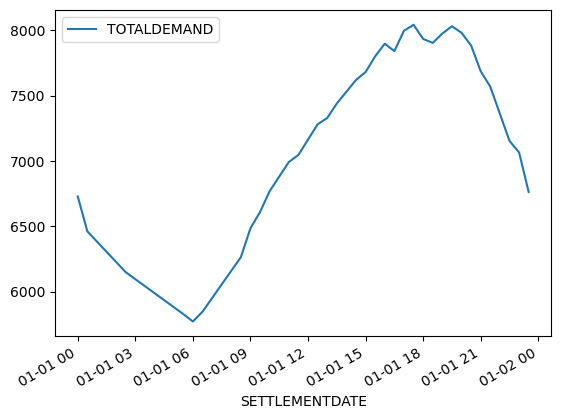

In [98]:
(df2.loc[df2.REGIONID == "QLD1"].loc["2017-01-01"]).plot()

/jobfs/95687832.gadi-pbs/ipykernel_3620848/1066274955.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2.loc[df2.REGIONID == "QLD1"].loc["2017-01-01"].resample("30min").mean().plot()


<AxesSubplot: xlabel='SETTLEMENTDATE'>

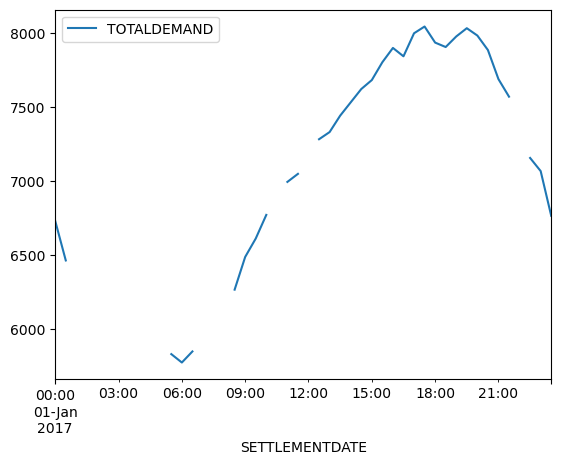

In [97]:
df2.loc[df2.REGIONID == "QLD1"].loc["2017-01-01"].resample("30min").mean().plot()

In [100]:
df2.loc[df2.REGIONID == "QLD1"].loc["2017-01-01"].resample("30min").mean()

/jobfs/95687832.gadi-pbs/ipykernel_3620848/3547218188.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df2.loc[df2.REGIONID == "QLD1"].loc["2017-01-01"].resample("30min").mean()


,TOTALDEMAND
SETTLEMENTDATE,
2017-01-01 00:00:00,6728.99
2017-01-01 00:30:00,6462.14
2017-01-01 01:00:00,NaN
2017-01-01 01:30:00,NaN
2017-01-01 02:00:00,NaN
2017-01-01 02:30:00,6149.87
2017-01-01 03:00:00,NaN
2017-01-01 03:30:00,NaN
2017-01-01 04:00:00,NaN


In [82]:
df2.index

DatetimeIndex(['2009-12-01 00:30:00', '2009-12-01 00:30:00',
               '2009-12-01 00:30:00', '2009-12-01 00:30:00',
               '2009-12-01 00:30:00', '2009-12-01 01:00:00',
               '2009-12-01 01:00:00', '2009-12-01 01:00:00',
               '2009-12-01 01:00:00', '2009-12-01 01:00:00',
               ...
               '2021-01-31 21:30:00', '2021-01-31 22:00:00',
               '2021-01-31 22:00:00', '2021-01-31 22:30:00',
               '2021-01-31 22:30:00', '2021-01-31 23:00:00',
               '2021-01-31 23:00:00', '2021-01-31 23:30:00',
               '2021-02-01 00:00:00', '2021-02-01 00:00:00'],
              dtype='datetime64[ns]', name='SETTLEMENTDATE', length=609946, freq=None)

/jobfs/95687832.gadi-pbs/ipykernel_3620848/1026711087.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.loc[df.REGIONID == "QLD1"].loc["2017-12"].resample("D").sum().plot()


<AxesSubplot: xlabel='SETTLEMENTDATE'>

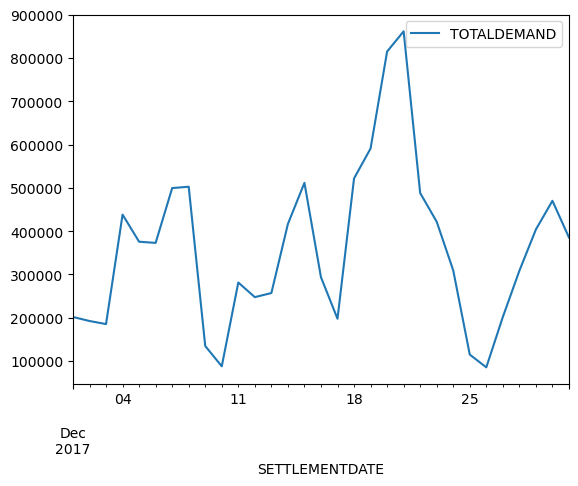

In [53]:
df.loc[df.REGIONID == "QLD1"].loc["2017-12"].resample("D").sum().plot()

<AxesSubplot: xlabel='SETTLEMENTDATE'>

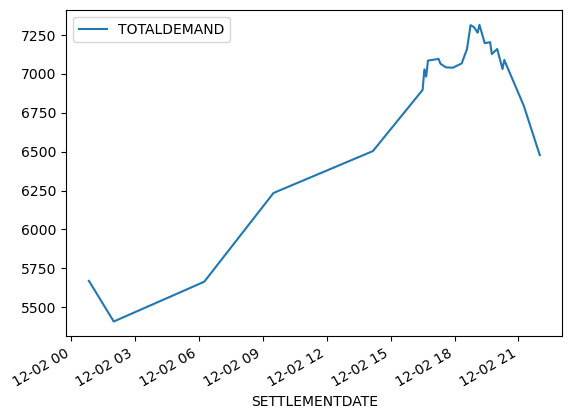

In [54]:
df.loc[df.REGIONID == "QLD1"].loc["2017-12-02"].plot()

In [49]:
df.loc[df.REGIONID == "QLD1"].loc["2017-12-02"].sum()

REGIONID       QLD1QLD1QLD1QLD1QLD1QLD1QLD1QLD1QLD1QLD1QLD1QL...
TOTALDEMAND                                            3594479.2
dtype: object

In [50]:
df.loc[df.REGIONID == "QLD1"].loc["2017-12-02"]

,REGIONID,TOTALDEMAND
SETTLEMENTDATE,,
2017-12-02 00:00:00,QLD1,5851.75
2017-12-02 00:00:00,QLD1,5851.75
2017-12-02 00:05:00,QLD1,5909.44
2017-12-02 00:05:00,QLD1,5909.44
2017-12-02 00:10:00,QLD1,5858.56
...,...,...
2017-12-02 23:45:00,QLD1,6037.25
2017-12-02 23:50:00,QLD1,5941.48
2017-12-02 23:50:00,QLD1,5941.48
